In [ ]:

%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from fastai2.vision.all import *
from fastai2.tabular.all import *
from fastai2.data.load import _FakeLoader, _loaders
import pandas as pd

In [ ]:
from fastai2.data.load import _FakeLoader, _loaders
class MixedDL():
    def __init__(self, tab_dl:TabDataLoader, vis_dl:TfmdDL, device='cuda:0'):
        "Stores away `tab_dl` and `vis_dl`, and overrides `shuffle_fn`"
        self.device = device
        tab_dl.shuffle_fn = self.shuffle_fn
        vis_dl.shuffle_fn = self.shuffle_fn
        self.dls = [tab_dl, vis_dl]
        self.count = 0
        self.fake_l = _FakeLoader(self, False, 0, 0)


In [ ]:
@patch
def shuffle_fn(x:MixedDL, idxs):
        "Generates a new `rng` based upon which `DataLoader` is called"
        if x.count == 0: # if we haven't generated an rng yet
            x.rng = x.dls[0].rng.sample(idxs, len(idxs))
            x.count += 1
            return x.rng
        else:
            x.count = 0
            return x.rng

@patch
def __iter__(dl:MixedDL):
        "Iterate over your `DataLoader`"
        z = zip(*[_loaders[i.fake_l.num_workers==0](i.fake_l) for i in dl.dls])
        for b in z:
            if dl.device is not None:
                b = to_device(b, dl.device)
            batch = []
            batch.extend(dl.dls[0].after_batch(b[0])[:2]) # tabular cat and cont
            batch.append(dl.dls[1].after_batch(b[1][0])) # Image
            batch.append(b[1][1]) # y
            yield tuple(batch)

@patch
def one_batch(x:MixedDL):
        "Grab a batch from the `DataLoader`"
        with x.fake_l.no_multiproc(): res = first(x)
        if hasattr(x, 'it'): delattr(x, 'it')
        return res

@patch
def __len__(x:MixedDL): return len(x.dls[0])

@patch
def to(x:MixedDL, device): x.device = device

@patch
def show_batch(x:MixedDL):
    "Show a batch from multiple `DataLoaders`"
    for dl in x.dls:
        dl.show_batch()

@patch
def show_results(x:MixedDL,b,out,**kwargs):
    "Show a batch from multiple `DataLoaders`"
    for i,dl in enumerate(x.dls):
        if i == 0:
            dl.show_results(b=b[:2]+(b[3],),out=out,**kwargs)
        else:
            dl.show_results(b=b[2:],out=out,**kwargs)

@patch
def new(x:MixedDL,*args,**kwargs):
    "Show a batch from multiple `DataLoaders`"
    new_dls = [dl.new() for dl in x.dls]
    res=MixedDL(*new_dls)
    return res

In [ ]:
path = "/home/mrdbarros/projetos/data/csgo_analyze/processed/de_mirage"
image_files = get_image_files(path)
tabular_files = get_files(path, extensions=['.csv'])
print(len(image_files))
print(len(tabular_files))

11860
255


In [ ]:
def fileLabeller(o,**kwargs):
    winnerFile = Path(o).parent/"winner.txt"
    if os.path.isfile(winnerFile):
        f = open(winnerFile, "r")
        winner = f.readline()
        f.close()
    else:
        winner="na"
    return winner

print(image_files[0])
print(fileLabeller(image_files[0]))

/home/mrdbarros/projetos/data/csgo_analyze/processed/de_mirage/6/ct_2_t_3/output_map16.jpg
ct


In [ ]:
columns = ['t_1','t_2','t_3','t_4','t_5','ct_1','ct_2','ct_3','ct_4','ct_5','related_image','winner']
full_csv = pd.DataFrame(columns=columns)
for tab_file in tabular_files:
    if not os.stat(tab_file).st_size == 0 and os.path.isfile(tab_file.parent/"winner.txt"):
        new_csv = pd.read_csv(tab_file, header=None)
        new_csv['index']=new_csv.index
        new_csv['related_image'] = str(tab_file.parent)+"/output_map"+new_csv['index'].astype(str)+".jpg"
        new_csv['winner'] = fileLabeller(tab_file)
        new_csv=new_csv.drop(columns=["index"])
        new_csv.columns=columns
        full_csv=full_csv.append(new_csv)


In [ ]:
filtered_image_files = L()
for image_file in image_files:
    if fileLabeller(image_file) in ["t","ct"] and not os.stat(image_file.parent/"tabular.csv").st_size == 0 and str(image_file) in full_csv['related_image'].values:
        filtered_image_files.append(image_file)

In [ ]:
filtered_image_files.sort()
full_csv=full_csv.sort_values(by=['related_image'])
splits=RandomSplitter()(filtered_image_files)

In [ ]:
print(filtered_image_files[55])
full_csv.iloc[55,:]

/home/mrdbarros/projetos/data/csgo_analyze/processed/de_mirage/10/ct_0_t_1/output_map59.jpg


t_1                                                                                                     0.65
t_2                                                                                                        0
t_3                                                                                                     0.37
t_4                                                                                                        0
t_5                                                                                                        0
ct_1                                                                                                       1
ct_2                                                                                                       1
ct_3                                                                                                       0
ct_4                                                                                                    0.25
ct_5               

In [ ]:
cont_names = ['t_1', 't_2','t_3','t_4','t_5','ct_1','ct_2','ct_3','ct_4','ct_5',]
for cat in cont_names:
    full_csv[cat]=full_csv[cat].astype(np.float)
procs = [Categorify, Normalize]
dls_tabular = TabularDataLoaders.from_df(full_csv, path, procs=procs, cont_names=cont_names,
                                 y_names="winner", bs=8,valid_idx=splits[1],device=torch.device('cuda:0'))

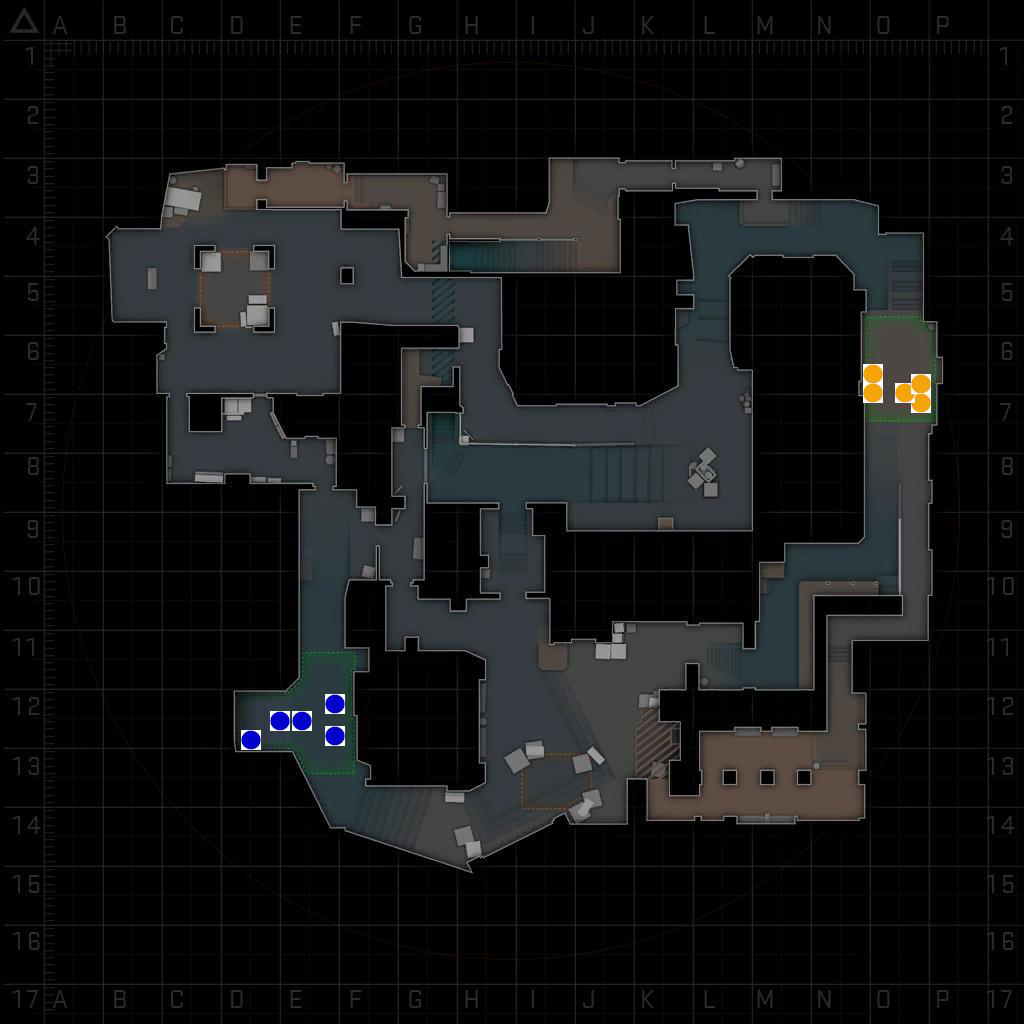

In [ ]:
PILImage.create(filtered_image_files[0])


In [ ]:

dsets = Datasets(filtered_image_files, [[PILImage.create], [fileLabeller, Categorize]],splits=splits)
item_tfms = [Resize(200),ToTensor]
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
dls_image = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=8, num_workers=8,device=torch.device("cuda"))

In [ ]:
train_mixed_dl = MixedDL(dls_tabular.train, dls_image.train)
train_mixed_dl.to(torch.device('cuda:0'))
valid_mixed_dl = MixedDL(dls_tabular.valid,dls_image.valid)
valid_mixed_dl.to(torch.device('cuda:0'))
dls = DataLoaders(train_mixed_dl, valid_mixed_dl,device=torch.device('cuda:0'))

In [ ]:
dls_image.one_batch()

(TensorImage([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.0665, -2.1008],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.0837, -2.1008],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.0837, -2.1008]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -1.9832, -2.0182],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0007, -2.0182],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0007, -2.0182]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
        

In [ ]:
dls_tabular.one_batch()

(tensor([], device='cuda:0', size=(8, 0), dtype=torch.int64),
 tensor([[ 0.6156, -1.6372, -1.6869, -1.7344, -1.7931, -1.7950, -1.8508, -1.7072,
          -1.3016, -1.8014],
         [ 0.6156, -1.4069,  0.6479,  0.6468,  0.6130,  0.6019, -1.8508,  0.2730,
          -1.8357, -1.8014],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [-1.8417, -1.6372, -1.6869, -1.7344, -1.7931, -1.7950, -1.3401, -1.7072,
          -1.8357,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927]], device='cuda:0'),
 tensor([[1],
         [1],
   

In [ ]:
b=train_mixed_dl.one_batch()
b

(tensor([], device='cuda:0', size=(8, 0), dtype=torch.int64),
 tensor([[ 0.6156,  0.6659, -0.1927,  0.6468,  0.6130,  0.6019, -0.3431,  0.6224,
           0.5921,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [ 0.3945,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019, -1.8508,  0.6224,
          -0.5490, -0.9635],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468, -1.7931,  0.6019,  0.5810,  0.6224,
           0.5921,  0.5927],
         [ 0.6156,  0.6659,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810,  0.0167,
           0.5921,  0.5927],
         [ 0.6156, -0.0711,  0.6479,  0.6468,  0.6130,  0.6019,  0.5810, -1.7072,
           0.3008,  0.5927],
         [ 0.6156,  0.4817,  0.6479, -1.7344,  0.6130,  0.6019,  0.5810, -1.2646,
          -1.8357,  0.5927]], device='cuda:0'),
 TensorImage([[[[-2.1179, -2.11

,t_1,t_2,t_3,t_4,t_5,ct_1,ct_2,ct_3,ct_4,ct_5,winner
0,1.00,1.00,0.64,1.000000e+00,1.0,1.0,0.62,1.00,1.00,1.00,ct
1,1.00,1.00,1.00,1.000000e+00,1.0,1.0,1.00,1.00,1.00,1.00,t
2,0.91,1.00,1.00,1.000000e+00,1.0,1.0,0.00,1.00,0.53,0.35,t
3,1.00,1.00,1.00,1.000000e+00,1.0,1.0,1.00,1.00,1.00,1.00,ct
4,1.00,1.00,1.00,1.000000e+00,0.0,1.0,1.00,1.00,1.00,1.00,ct
5,1.00,1.00,1.00,1.000000e+00,1.0,1.0,1.00,0.74,1.00,1.00,t
6,1.00,0.68,1.00,1.000000e+00,1.0,1.0,1.00,0.00,0.88,1.00,t
7,1.00,0.92,1.00,5.960464e-08,1.0,1.0,1.00,0.19,0.00,1.00,ct


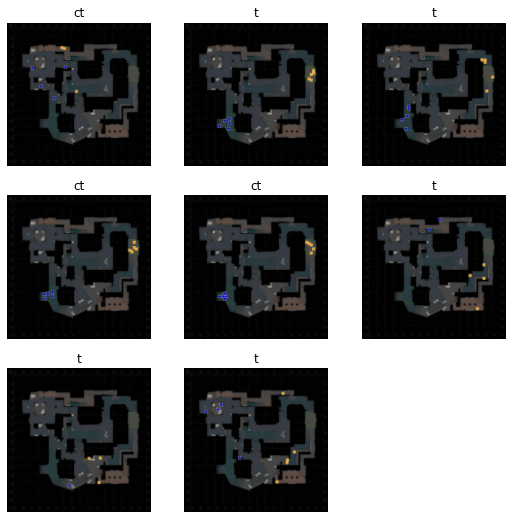

In [ ]:
train_mixed_dl.show_batch()



In [ ]:
class CustomMixedModel(nn.Module):
    def __init__(self, resNet):
        super(CustomMixedModel,self).__init__()
        self.resNet = resNet
        #self.classifier = TabularModel_NoCat(emb_sizes,1536, 30,[400],ps=[0.1],use_bn=False)

        #self.embeds = nn.ModuleList([embedding(ni, nf) for ni, nf in emb_sizes])
        #n_emb = sum(e.embedding_dim for e in self.embeds)
        self.intermediate_linear = nn.Sequential(torch.nn.Linear(10,200),nn.ReLU())
        self.classifier=torch.nn.Linear(1200,2)

        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, input_cat,input_cont,input_image):
        #pdb.set_trace()
        output_image =self.resNet(input_image)
        output_tabular = self.intermediate_linear(input_cont)

        output=self.dropout(torch.cat((output_tabular, output_image), dim=1))

        logits = self.classifier(output)
        return logits

In [ ]:
image_model =xresnet34()
image_model.to("cuda:0")
model = CustomMixedModel(image_model)
model = model.to("cuda:0")

In [ ]:
model(*b[:-1])

tensor([[ 0.0991,  0.3460],
        [ 0.2976,  0.0637],
        [ 0.1652,  0.1010],
        [ 0.0765,  0.1924],
        [ 0.0945,  0.4028],
        [ 0.0153, -0.0572],
        [ 0.3414, -0.0206],
        [-0.1041, -0.1118]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

In [ ]:
#learn.lr_find()

In [ ]:
learn.fine_tune(3, 5e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.487267,0.577993,0.731890,03:01


epoch,train_loss,valid_loss,accuracy,time
0,0.451332,0.552899,0.762809,03:08
1,0.436944,0.481164,0.803887,03:13
2,0.406602,0.484453,0.808746,03:32


,t_1,t_2,t_3,t_4,t_5,ct_1,ct_2,ct_3,ct_4,ct_5,winner,winner_pred
0,0.615644,0.665914,0.647853,0.646789,0.612982,0.601907,0.581023,0.622415,0.592106,0.592698,1.0,0.0
1,0.615644,0.665914,0.157558,-1.734444,0.588921,0.601907,0.581023,0.622415,0.592106,0.329349,1.0,1.0
2,-1.841735,-1.637170,-1.243286,-1.734444,-1.793131,0.601907,-1.850835,-1.707193,-1.835735,-1.801384,0.0,1.0
3,0.075021,-1.637170,0.647853,-1.734444,-0.854746,-1.795008,-1.850835,-1.707193,0.592106,-1.801384,1.0,1.0
4,-1.841735,0.665914,0.040821,0.646789,-1.793131,0.601907,-1.850835,0.622415,0.592106,0.592698,0.0,0.0
5,0.615644,-1.637170,0.367684,-1.734444,-1.793131,-1.795008,-0.075579,-1.707193,0.592106,0.592698,0.0,0.0
6,0.615644,0.665914,0.647853,0.646789,0.612982,0.601907,0.581023,0.622415,0.592106,0.592698,1.0,1.0
7,-1.841735,-1.637170,-1.686887,-1.734444,0.083638,-1.795008,0.581023,-1.707193,-1.835735,-1.801384,1.0,1.0


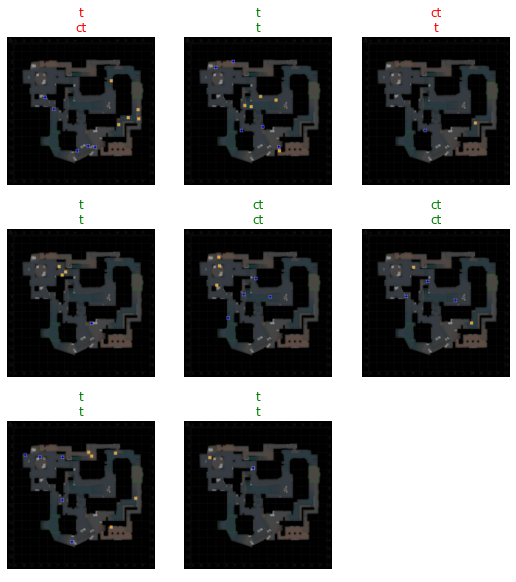

In [ ]:
learn.show_results()